In [1]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
tf.keras.backend.set_floatx('float32')
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize the images, between 0  and 1
x_train, x_test = x_train / 255.0 , x_test / 255.0 

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
    
print(x_train.shape)
#(60000, 28, 28, 1)

print(y_train.shape)
(60000,)

print(x_test.shape)
#(10000, 28, 28, 1)

print(y_test.shape)
#(10000,)

num_class = 10

# Convert labels to one hot encoded vectors.
y_train_oh, y_test_oh = tf.keras.utils.to_categorical(y_train, num_classes= num_class, dtype='float32'), tf.keras.utils.to_categorical(y_test, num_classes= num_class, dtype='float32')

print(y_train_oh.shape)
#(60000, 10)
print(y_test_oh.shape)
#(10000, 10)

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_oh)).shuffle(60000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_oh)).batch(batch_size)

Tensorflow version:  2.1.0
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)
(60000, 10)
(10000, 10)


In [2]:
IMG_SIZE = (28, 28, 1)
input_img = tf.keras.layers.Input(shape=IMG_SIZE)

model = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(input_img)
model = tf.keras.layers.Activation('relu')(model)
model = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2))(model)
model = tf.keras.layers.Activation('relu')(model)

model = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(model)
model = tf.keras.layers.Activation('relu')(model)
model = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2))(model)
model = tf.keras.layers.Activation('relu')(model)

model = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(model)
model = tf.keras.layers.Activation('relu')(model)
model = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(model)
model = tf.keras.layers.Activation('relu')(model)

model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(32)(model)
model = tf.keras.layers.Activation('relu')(model)
output_img = tf.keras.layers.Dense(10)(model)
#output_img = tf.keras.layers.Activation('softmax')(model)

model = tf.keras.models.Model(input_img, output_img)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0     

In [3]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# This function accepts one-hot encoded labels

model.compile(adam, loss=loss_object, metrics=["accuracy"])

history = model.fit(x_train, y_train_oh, epochs=5, 
                    validation_data=(x_test,  y_test_oh))

model.reset_metrics()

# Save the model
model.save('my_model_deepfool.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.3052 - accuracy: 0.8982 - val_loss: 0.0714 - val_accuracy: 0.9769
Epoch 2/5
60000/60000 [==============================] - 60s 1000us/sample - loss: 0.0646 - accuracy: 0.9808 - val_loss: 0.0465 - val_accuracy: 0.9857
Epoch 3/5
60000/60000 [==============================] - 58s 974us/sample - loss: 0.0494 - accuracy: 0.9852 - val_loss: 0.0322 - val_accuracy: 0.9896
Epoch 4/5
60000/60000 [==============================] - 59s 976us/sample - loss: 0.0417 - accuracy: 0.9877 - val_loss: 0.0484 - val_accuracy: 0.9863
Epoch 5/5
60000/60000 [==============================] - 58s 971us/sample - loss: 0.0332 - accuracy: 0.9901 - val_loss: 0.0402 - val_accuracy: 0.9878


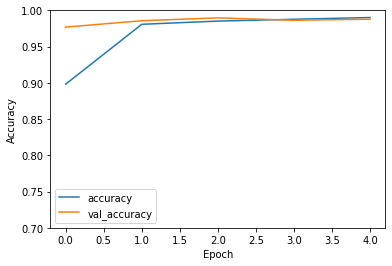

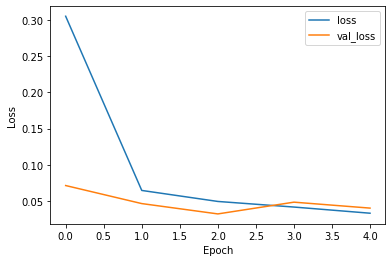

In [4]:
plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='best')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

In [5]:
test_loss, test_accuracy = model.evaluate(x_test,  y_test_oh, verbose=2)

print('\nTest accuracy = {0:.2f}%'.format(test_accuracy*100.0))

10000/10000 - 2s - loss: 0.0402 - accuracy: 0.9878

Test accuracy = 98.78%


# DeepFool for multiclass classifiers

ORIGINAL PAPER --> https://arxiv.org/pdf/1511.04599.pdf

Deepfool is an untargeted attack technique optimized for the L2 distance metric.
    
The most common used scheme for multiclass classifiers is one-vs-all. In this scheme, the classifier has $c$ outputs where $c$ is the number of classes. Therefore, a classifier can be defined as $f : R^{n} \rightarrow R^{c}$ and the classification is done by the following mapping:

$$
\hat{k}(x) = \underset{k}{\mathrm{argmax}} f_{k}(x),
$$

where $f_{k}(x)$ is the output of $f(x)$ that corresponds to the $k$th class (logits for the $k$th class).

![](deepfool_multiclass_case.png)

Note that here, the output layer must be the final layer of the trained model right before the softmax.

* 1. Input is an image $x$ and the classifier $f$, which is the model.
* 2. The output which is the perturbation ($r_{total}$)
* 3. [Blank]
* 4. We initialize the perturbed image with the original image and the loop variable. ($X_{adv}$)
* 5. We start the iteration and continue until the original label ($\text{label}$) and the perturbed label ($k_{i}$) are not equal, i.e., ($k_{i} == \text{label}$). In other words, The search terminates when a true adversarial example is found.
* 6-9.  We consider n classes that had the most probability after the original class and we store the minimum difference between the original gradients along with the gradients of each of these classes ($w_{k}$) and the difference in the labels ($f_{k}$).
* 10. The inner loop stores the minimum $w_{k}$ and $f_{k}$, and using this we calculate the closest hyperplane for the input $x$ (See the formula below how to calculate the closest hyperplane)
* 11. We calculate the minimal vector that projects $x$ onto the closest hyperplane that we calculated in 10.
* 12. We add the minimal perturbation to the image and check if it’s misclassified.
* 13–14. Loop variable increased; End Loop ($\text{loop}_{i}$).
* 15. Return the total perturbation, which is a sum over all the calculated perturbations.

Alright, let’s now look at two equations:

![](deepfool1.png)

This is the algorithm that helps you calculate the closest hyperplane given an input $x_{0}$, where, 
* variables starting with $f$ are the class labels
* variables starting with $w$ are the gradients

Among them, the variables with $k$ as subscript are for the classes with the most probability after the true class, and the variables with subscript $\hat{k}_{x_{0}}$ is for the true class. Given an input, it goes among the top classes with the most probability after the true class and calculates and stores the closest hyperplane; this is done in lines 6-10 of the algorithm. And this one:

![](deepfool2.png)

This is the algorithm that calculates the minimal perturbation needed, i.e. this calculates the projection of the input on the closest hyperplane! This is done in line 11 of the algorithm.

And that’s all! 

In [6]:
num_classes=10
image_array = x_train[2300]
#(1, 28, 28, 1)

logits_image = model(image_array.numpy().reshape(-1,28,28,1)) #shape=(1, 10)
predictions_image = tf.nn.softmax(logits_image).numpy() #shape=(1, 10)
confidence_image = predictions_image.max() * 100
class_idx = predictions_image.argmax()

I = predictions_image.flatten().argsort()[::-1]
I = I[0:num_classes] #choosing the first num_classes elements
#array([5, 9, 6, 8, 4, 0, 3, 7, 2, 1])

label = I[0] #the first element is our true label
print(label)
#6

6


In [7]:
overshoot=0.02
max_iter = 50

input_shape = np.shape(image_array)
# (1, 28, 28, 1)

# We initialize the perturbed image with the original image ...
X_adv = tf.reshape(image_array,(-1,28,28,1))
#(1, 28, 28, 1)

k_i = label

#... and the loop variable.
iters = 0

w = np.zeros(input_shape)
#(1, 28, 28, 1)

r_total  = np.zeros(input_shape)
#(1, 28, 28, 1)

#We start the iteration and continue until the original label and the perturbed label are not equal.
while k_i == label and iters < max_iter:
    pert = np.inf
    
    with tf.GradientTape() as tape:
        tape.watch(X_adv)
        logits = model(X_adv)
        val = logits[0, I[0]]
    grad_orig = tape.gradient(val, X_adv)  #shape=(1, 28, 28, 1)

    # We consider n classes that had the most probability after the original class (In this example, we are using all the classes because number of classes
    # is not big but for other datasets, such as ImageNet where num_classes = 10000, we can choose num_classes.)
    for k in range(1, num_classes):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            logits = model(X_adv)
            val = logits[0, I[k]]
        cur_grad = tape.gradient(val, X_adv)  #shape=(1, 28, 28, 1)
                
        w_k = cur_grad - grad_orig
        #shape=(1, 28, 28, 1)
        
        f_k = (logits[0, I[k]] - logits[0, I[0]]).numpy()
        
        pert_k = abs(f_k) / np.linalg.norm(tf.reshape(w_k, [-1]))
        
        if pert_k < pert:
            pert = pert_k
            w = w_k
            
    r_i = (pert + 1e-4) * w / np.linalg.norm(w) #it is L2 norm
    r_total = np.float32(r_total + r_i)

    X_adv = image_array + (1 + overshoot) * r_total
    
    logits = model(X_adv)
    k_i = np.argmax(np.array(logits).flatten())
    
    iters += 1
    
r_total = (1 + overshoot) * r_total

In [8]:
logits_image_adv = model(X_adv) #shape=(1, 10) 
#you can also use model.predict(X_adv)
predictions_image_adv = tf.nn.softmax(logits_image_adv).numpy() #shape=(1, 10)
confidence_image_adv = predictions_image_adv.max() * 100
class_idx_adv = predictions_image_adv.argmax()

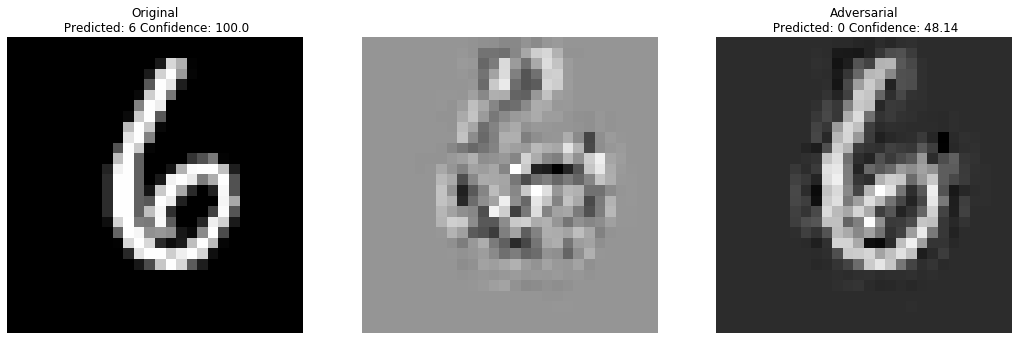

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,18))

confidence = str(round(confidence_image,2))
pixels = image_array.numpy().reshape((28, 28))
axes[0].imshow(pixels, cmap='gray')
axes[0].set_axis_off()
title = 'Original\n Predicted: {0} Confidence: {1}'
axes[0].set_title(title.format(class_idx, confidence))

pixels = r_total[0].reshape((28, 28))
axes[1].imshow(pixels, cmap='gray')
axes[1].set_axis_off()

confidence = str(round(confidence_image_adv,2))
pixels = X_adv[0].numpy().reshape((28, 28))
axes[2].imshow(pixels, cmap='gray')
axes[2].set_axis_off()
title = 'Adversarial\n Predicted: {0} Confidence: {1}'
axes[2].set_title(title.format(class_idx_adv, confidence))

plt.show()